In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, 
    roc_auc_score, 
    f1_score, 
    accuracy_score,
    confusion_matrix,
    classification_report
)
import optuna
import lightgbm as lgb
# import xgboost as xgb
# from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

# 再現性のためのシード設定
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [6]:
train_df = pd.read_csv("/home/takato/bita/bank/data/train.csv")
test_df = pd.read_csv("/home/takato/bita/bank/data/test.csv")

In [8]:
def feature_engineering(df, is_train=True, encoders=None):
    """
    特徴量エンジニアリング関数
    
    Parameters:
    -----------
    df : DataFrame
        処理対象のデータフレーム
    is_train : bool
        訓練データの場合True、テストデータの場合False
    encoders : dict
        テストデータ処理時に使用するエンコーダー辞書
        {'target_encoders': {...}, 'label_encoders': {...}, 'freq_encoders': {...}}
    
    Returns:
    --------
    df : DataFrame
        特徴量エンジニアリング済みのデータフレーム
    encoders : dict or None
        訓練時はエンコーダー辞書を返す、テスト時はNone
    """
    df = df.copy()
    
    # 1. 数値特徴量の変換
    # 年齢グループ
    df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100], 
                              labels=['0-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    # balance の対数変換（負の値があるため調整）
    df['balance_log'] = np.log1p(df['balance'] - df['balance'].min() + 1)
    
    # 2. 時系列特徴量
    # dayとduration の比率
    df['duration_per_day'] = df['duration'] / (df['day'] + 1)
    
    # campaign効率
    df['campaign_efficiency'] = df['duration'] / (df['campaign'] + 1)
    
    # previous の成功率（pdaysが999でない場合）
    df['has_previous_contact'] = (df['pdays'] != 999).astype(int)
    df['previous_success_rate'] = df['previous'] / (df['pdays'].replace(999, 1) + 1)
    
    # 3. 月のマッピング
    month_mapping = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    # 数値変換
    df['month_numeric'] = df['month'].map(month_mapping)

    # 周期性エンコーディング
    df['month_sin'] = np.sin(2 * np.pi * df['month_numeric'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_numeric'] / 12)

    df = df.drop(columns=['month','month_numeric'])
    
    # 4. ローン関連の特徴量
    df['total_loans'] = (df['housing'] == 'yes').astype(int) + (df['loan'] == 'yes').astype(int)
    df['has_any_loan'] = (df['total_loans'] > 0).astype(int)
    
    # 5. カテゴリカル変数のリスト
    categorical_feats = ['job', 'marital', 'education', 'contact', 'poutcome', 'age_group']
    zero_and_one_list = ['default', 'housing','loan']
    for col in zero_and_one_list:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    
    if is_train:
        # 訓練データ：エンコーダーを作成
        target_encoders = {}
        label_encoders = {}
        freq_encoders = {}
        
        # 6. Target Encoding（訓練データのみで学習）
        for col in categorical_feats:
            if 'y' in df.columns:
                target_mean = df.groupby(col)['y'].mean()
                # Smoothingを適用
                global_mean = df['y'].mean()
                counts = df.groupby(col).size()
                smoothing = 10
                smooth_target = (target_mean * counts + global_mean * smoothing) / (counts + smoothing)
                target_encoders[col] = smooth_target
                df[f'{col}_target_enc'] = df[col].map(smooth_target)
        
        # 7. Frequency Encoding
        for col in categorical_feats:
            freq = df[col].value_counts(normalize=True)
            freq_encoders[col] = freq
            df[f'{col}_freq'] = df[col].map(freq)
        
        # 8. Label Encoding（訓練時に学習）
        for col in categorical_feats:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        
        # エンコーダーをまとめて返す
        encoders = {
            'target_encoders': target_encoders,
            'label_encoders': label_encoders,
            'freq_encoders': freq_encoders
        }
        return df, encoders
    
    else:
        # テストデータ：訓練時のエンコーダーを使用
        if encoders is None:
            raise ValueError("テストデータ処理時にはencodersを渡す必要があります")
        
        target_encoders = encoders['target_encoders']
        label_encoders = encoders['label_encoders']
        freq_encoders = encoders['freq_encoders']
        
        # 6. Target Encoding（訓練時の値を使用）
        for col in categorical_feats:
            if col in target_encoders:
                df[f'{col}_target_enc'] = df[col].map(target_encoders[col])
                # 未知のカテゴリには平均値を使用
                # 修正後（明示的にfloat型に変換）
                df[f'{col}_target_enc'] = df[f'{col}_target_enc'].astype('float64')
                df[f'{col}_target_enc'].fillna(target_encoders[col].mean(), inplace=True)
        
        # 7. Frequency Encoding（訓練時の頻度を使用）
        for col in categorical_feats:
            if col in freq_encoders:
                df[f'{col}_freq'] = df[col].map(freq_encoders[col])
                # 未知のカテゴリには最小頻度を使用
                df[f'{col}_freq'].fillna(freq_encoders[col].min(), inplace=True)
        
        # 8. Label Encoding（訓練時のエンコーダーを使用）
        for col in categorical_feats:
            if col in label_encoders:
                le = label_encoders[col]
                # 未知のカテゴリを処理
                df[col] = df[col].astype(str).apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )
        
        return df, None

# 特徴量エンジニアリングを適用
train_processed, encoders = feature_engineering(train_df, is_train=True)
print("Feature engineering completed!")
print(f"New train shape: {train_processed.shape}")

Feature engineering completed!
New train shape: (27128, 39)


In [9]:
# ターゲットと特徴量の分離
y = train_processed['y']
exclude_cols = ['id', 'y']
X = train_processed.drop(columns=exclude_cols)

print(f"Features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")

# Train/Valid分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Valid set: {X_valid.shape}")

Features: 37

Feature names: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'age_group', 'balance_log', 'duration_per_day', 'campaign_efficiency', 'has_previous_contact', 'previous_success_rate', 'month_sin', 'month_cos', 'total_loans', 'has_any_loan', 'job_target_enc', 'marital_target_enc', 'education_target_enc', 'contact_target_enc', 'poutcome_target_enc', 'age_group_target_enc', 'job_freq', 'marital_freq', 'education_freq', 'contact_freq', 'poutcome_freq', 'age_group_freq']

Train set: (21702, 37)
Valid set: (5426, 37)


In [10]:
def objective_lgb(trial):
    """
    LightGBMのハイパーパラメータ最適化
    """
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "n_estimators": 2000,
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "random_state": RANDOM_STATE,
        "class_weight": "balanced"  # 不均衡データ対応
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    preds = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)
    return auc

# 最適化実行（より多くのトライアル）
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=100, show_progress_bar=True)

print("Best AUC (LightGBM):", study_lgb.best_value)
print("Best params (LightGBM):", study_lgb.best_params)

[I 2025-11-10 01:44:35,348] A new study created in memory with name: no-name-57584887-cf2e-4859-b06b-d9952ddb2e16
Best trial: 0. Best value: 0.906133:   1%|          | 1/100 [00:00<00:55,  1.77it/s]

[I 2025-11-10 01:44:35,913] Trial 0 finished with value: 0.9061333832957794 and parameters: {'learning_rate': 0.027550805070871605, 'num_leaves': 118, 'max_depth': 6, 'min_child_samples': 77, 'subsample': 0.9277013087252753, 'colsample_bytree': 0.9619763075573459, 'reg_alpha': 0.0007008027177235507, 'reg_lambda': 0.0723623284409894, 'min_split_gain': 0.5491543328158781}. Best is trial 0 with value: 0.9061333832957794.


Best trial: 0. Best value: 0.906133:   2%|▏         | 2/100 [00:01<01:40,  1.03s/it]

[I 2025-11-10 01:44:37,268] Trial 1 finished with value: 0.904982932236789 and parameters: {'learning_rate': 0.007055088595177974, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 95, 'subsample': 0.6775845124589579, 'colsample_bytree': 0.6244455216779643, 'reg_alpha': 4.043652536311974, 'reg_lambda': 0.024069776778676527, 'min_split_gain': 0.9914178701586404}. Best is trial 0 with value: 0.9061333832957794.


Best trial: 2. Best value: 0.906899:   3%|▎         | 3/100 [00:02<01:16,  1.27it/s]

[I 2025-11-10 01:44:37,768] Trial 2 finished with value: 0.9068985976001591 and parameters: {'learning_rate': 0.03580521788851235, 'num_leaves': 232, 'max_depth': 15, 'min_child_samples': 91, 'subsample': 0.8098724543367035, 'colsample_bytree': 0.838669750983399, 'reg_alpha': 0.00027476730214171516, 'reg_lambda': 2.3808868973006253e-06, 'min_split_gain': 0.7700930705842385}. Best is trial 2 with value: 0.9068985976001591.


Best trial: 2. Best value: 0.906899:   4%|▍         | 4/100 [00:02<01:06,  1.44it/s]

[I 2025-11-10 01:44:38,321] Trial 3 finished with value: 0.9061327258951742 and parameters: {'learning_rate': 0.043732049180369326, 'num_leaves': 118, 'max_depth': 14, 'min_child_samples': 31, 'subsample': 0.7299062972507779, 'colsample_bytree': 0.8550356203254099, 'reg_alpha': 1.4026585891222467e-06, 'reg_lambda': 1.127831131203735, 'min_split_gain': 0.24143741178419886}. Best is trial 2 with value: 0.9068985976001591.


Best trial: 2. Best value: 0.906899:   5%|▌         | 5/100 [00:03<01:02,  1.52it/s]

[I 2025-11-10 01:44:38,912] Trial 4 finished with value: 0.9051926430298279 and parameters: {'learning_rate': 0.017821471981131348, 'num_leaves': 192, 'max_depth': 4, 'min_child_samples': 87, 'subsample': 0.6710480161011418, 'colsample_bytree': 0.9061370950019024, 'reg_alpha': 5.338222974912618e-06, 'reg_lambda': 5.736915805918868e-08, 'min_split_gain': 0.07992540748505428}. Best is trial 2 with value: 0.9068985976001591.


Best trial: 5. Best value: 0.907096:   6%|▌         | 6/100 [00:03<00:51,  1.83it/s]

[I 2025-11-10 01:44:39,243] Trial 5 finished with value: 0.9070964751823054 and parameters: {'learning_rate': 0.029455351043359435, 'num_leaves': 24, 'max_depth': 10, 'min_child_samples': 48, 'subsample': 0.8491453289858458, 'colsample_bytree': 0.6542101019775411, 'reg_alpha': 9.754231836795209e-05, 'reg_lambda': 0.0021987470413445376, 'min_split_gain': 0.7841385385881745}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:   7%|▋         | 7/100 [00:04<01:03,  1.46it/s]

[I 2025-11-10 01:44:40,210] Trial 6 finished with value: 0.9018086734148839 and parameters: {'learning_rate': 0.026579722181135777, 'num_leaves': 279, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7543695184614377, 'colsample_bytree': 0.9634359181529695, 'reg_alpha': 4.8510500663553636e-08, 'reg_lambda': 0.3098157298600644, 'min_split_gain': 0.509750409837317}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:   8%|▊         | 8/100 [00:05<00:51,  1.77it/s]

[I 2025-11-10 01:44:40,516] Trial 7 finished with value: 0.906273080924371 and parameters: {'learning_rate': 0.058005572500957114, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 75, 'subsample': 0.8331195796694755, 'colsample_bytree': 0.955379296274701, 'reg_alpha': 0.00018178018682117654, 'reg_lambda': 6.496780603929983e-06, 'min_split_gain': 0.6258072956598502}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:   9%|▉         | 9/100 [00:05<00:45,  2.01it/s]

[I 2025-11-10 01:44:40,867] Trial 8 finished with value: 0.9044752546194719 and parameters: {'learning_rate': 0.017495322035258026, 'num_leaves': 139, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7432034761888159, 'colsample_bytree': 0.7422774812884647, 'reg_alpha': 6.35826250632243e-08, 'reg_lambda': 1.0741942106779865, 'min_split_gain': 0.620953478573997}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:  10%|█         | 10/100 [00:05<00:38,  2.31it/s]

[I 2025-11-10 01:44:41,157] Trial 9 finished with value: 0.9052994706281627 and parameters: {'learning_rate': 0.031136490449384355, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 82, 'subsample': 0.8900368132987152, 'colsample_bytree': 0.6283240472160979, 'reg_alpha': 0.00021185596813269854, 'reg_lambda': 3.1000913952393736e-06, 'min_split_gain': 0.318474576232582}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:  11%|█         | 11/100 [00:06<00:48,  1.84it/s]

[I 2025-11-10 01:44:41,955] Trial 10 finished with value: 0.9070527580420638 and parameters: {'learning_rate': 0.009662665779271856, 'num_leaves': 25, 'max_depth': 9, 'min_child_samples': 48, 'subsample': 0.9996962138756883, 'colsample_bytree': 0.7290125772952784, 'reg_alpha': 0.210098760221712, 'reg_lambda': 0.001090109657928185, 'min_split_gain': 0.9505596687472411}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:  12%|█▏        | 12/100 [00:07<01:08,  1.29it/s]

[I 2025-11-10 01:44:43,254] Trial 11 finished with value: 0.9067786219897216 and parameters: {'learning_rate': 0.008306567453785123, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.9958809342084743, 'colsample_bytree': 0.7253134429967568, 'reg_alpha': 0.806599393483189, 'reg_lambda': 0.0005203488332081852, 'min_split_gain': 0.9762877230949579}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:  13%|█▎        | 13/100 [00:08<01:01,  1.41it/s]

[I 2025-11-10 01:44:43,812] Trial 12 finished with value: 0.9067667887788291 and parameters: {'learning_rate': 0.010321489384849185, 'num_leaves': 26, 'max_depth': 9, 'min_child_samples': 54, 'subsample': 0.9849913176257621, 'colsample_bytree': 0.70402514142278, 'reg_alpha': 0.0472627830542052, 'reg_lambda': 0.0007653407336904931, 'min_split_gain': 0.8156279771836678}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:  14%|█▍        | 14/100 [00:08<00:50,  1.70it/s]

[I 2025-11-10 01:44:44,121] Trial 13 finished with value: 0.9060553169739193 and parameters: {'learning_rate': 0.005203555879018214, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 50, 'subsample': 0.890503700268036, 'colsample_bytree': 0.6720325226383698, 'reg_alpha': 0.07143764335671872, 'reg_lambda': 0.004746655229427997, 'min_split_gain': 0.7842560346766656}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 5. Best value: 0.907096:  15%|█▌        | 15/100 [00:08<00:40,  2.11it/s]

[I 2025-11-10 01:44:44,334] Trial 14 finished with value: 0.9056794481779321 and parameters: {'learning_rate': 0.09607119813140902, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.6155148737880142, 'colsample_bytree': 0.7872574894612221, 'reg_alpha': 0.009545017646530677, 'reg_lambda': 5.161035108370732e-05, 'min_split_gain': 0.8833374828359528}. Best is trial 5 with value: 0.9070964751823054.


Best trial: 15. Best value: 0.907192:  16%|█▌        | 16/100 [00:09<00:49,  1.71it/s]

[I 2025-11-10 01:44:45,176] Trial 15 finished with value: 0.9071924556706554 and parameters: {'learning_rate': 0.013595937288783933, 'num_leaves': 24, 'max_depth': 7, 'min_child_samples': 35, 'subsample': 0.9348627264046637, 'colsample_bytree': 0.7851398120373593, 'reg_alpha': 1.4871295794471021e-05, 'reg_lambda': 8.179370118400747, 'min_split_gain': 0.6929405960465154}. Best is trial 15 with value: 0.9071924556706554.


Best trial: 15. Best value: 0.907192:  17%|█▋        | 17/100 [00:10<00:53,  1.54it/s]

[I 2025-11-10 01:44:45,972] Trial 16 finished with value: 0.9070156149078735 and parameters: {'learning_rate': 0.01426787000536668, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 33, 'subsample': 0.8558783043492728, 'colsample_bytree': 0.7980990597274136, 'reg_alpha': 2.5386552705151825e-06, 'reg_lambda': 4.999393353219464, 'min_split_gain': 0.6576275738333459}. Best is trial 15 with value: 0.9071924556706554.


Best trial: 15. Best value: 0.907192:  18%|█▊        | 18/100 [00:11<00:51,  1.58it/s]

[I 2025-11-10 01:44:46,567] Trial 17 finished with value: 0.9028940418139656 and parameters: {'learning_rate': 0.013104611197478161, 'num_leaves': 298, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.9319754572541965, 'colsample_bytree': 0.6008773683628296, 'reg_alpha': 2.167315086565048e-05, 'reg_lambda': 0.014062216789156182, 'min_split_gain': 0.4210653072057897}. Best is trial 15 with value: 0.9071924556706554.


Best trial: 15. Best value: 0.907192:  19%|█▉        | 19/100 [00:11<00:42,  1.90it/s]

[I 2025-11-10 01:44:46,844] Trial 18 finished with value: 0.9059210429003198 and parameters: {'learning_rate': 0.05694656257077631, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.9338695821386747, 'colsample_bytree': 0.675748775427931, 'reg_alpha': 3.7782131628086796e-07, 'reg_lambda': 1.1469109702222651e-08, 'min_split_gain': 0.7446924299997151}. Best is trial 15 with value: 0.9071924556706554.


Best trial: 19. Best value: 0.907756:  20%|██        | 20/100 [00:12<00:53,  1.49it/s]

[I 2025-11-10 01:44:47,852] Trial 19 finished with value: 0.9077558479892579 and parameters: {'learning_rate': 0.01903420291658181, 'num_leaves': 147, 'max_depth': 10, 'min_child_samples': 62, 'subsample': 0.8834742109927234, 'colsample_bytree': 0.771835528790923, 'reg_alpha': 0.003297794794396925, 'reg_lambda': 9.942436535834045, 'min_split_gain': 0.43948603494817007}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  21%|██        | 21/100 [00:13<01:00,  1.30it/s]

[I 2025-11-10 01:44:48,846] Trial 20 finished with value: 0.9066287346517502 and parameters: {'learning_rate': 0.01982328799410604, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 64, 'subsample': 0.8877728085930392, 'colsample_bytree': 0.8401318609331139, 'reg_alpha': 0.0029036279692107253, 'reg_lambda': 6.499600355332817, 'min_split_gain': 0.35591620143166514}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  22%|██▏       | 22/100 [00:14<00:58,  1.33it/s]

[I 2025-11-10 01:44:49,561] Trial 21 finished with value: 0.9055768936835306 and parameters: {'learning_rate': 0.02306414782563648, 'num_leaves': 155, 'max_depth': 10, 'min_child_samples': 59, 'subsample': 0.8653002994775943, 'colsample_bytree': 0.7813037195325155, 'reg_alpha': 6.237771212625447e-05, 'reg_lambda': 0.42056800290575524, 'min_split_gain': 0.6937727573696835}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  23%|██▎       | 23/100 [00:14<00:58,  1.31it/s]

[I 2025-11-10 01:44:50,344] Trial 22 finished with value: 0.9074826980378234 and parameters: {'learning_rate': 0.014721043616096713, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 40, 'subsample': 0.7892211598481601, 'colsample_bytree': 0.7578443809622983, 'reg_alpha': 0.0023494284435986515, 'reg_lambda': 9.287234115150248, 'min_split_gain': 0.5500773775558292}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  24%|██▍       | 24/100 [00:15<00:57,  1.32it/s]

[I 2025-11-10 01:44:51,094] Trial 23 finished with value: 0.9075037348571878 and parameters: {'learning_rate': 0.014682564479187005, 'num_leaves': 239, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.7908137424224074, 'colsample_bytree': 0.7624764019754601, 'reg_alpha': 0.003087426246564372, 'reg_lambda': 7.885101698059211, 'min_split_gain': 0.4244209262602568}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  25%|██▌       | 25/100 [00:17<01:08,  1.10it/s]

[I 2025-11-10 01:44:52,369] Trial 24 finished with value: 0.9067335900482696 and parameters: {'learning_rate': 0.014968903240600625, 'num_leaves': 247, 'max_depth': 10, 'min_child_samples': 40, 'subsample': 0.785998912294043, 'colsample_bytree': 0.7568724837495454, 'reg_alpha': 0.004245644387117223, 'reg_lambda': 0.12679341300501196, 'min_split_gain': 0.43728800094343667}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  26%|██▌       | 26/100 [00:18<01:09,  1.07it/s]

[I 2025-11-10 01:44:53,355] Trial 25 finished with value: 0.9057635954553896 and parameters: {'learning_rate': 0.011326279728732676, 'num_leaves': 206, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.7938535395600095, 'colsample_bytree': 0.8760393555260403, 'reg_alpha': 0.0015598950547744165, 'reg_lambda': 1.7480810193847676, 'min_split_gain': 0.23443403570684868}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  27%|██▋       | 27/100 [00:18<01:02,  1.16it/s]

[I 2025-11-10 01:44:54,037] Trial 26 finished with value: 0.9073140747826058 and parameters: {'learning_rate': 0.02107721545343016, 'num_leaves': 262, 'max_depth': 11, 'min_child_samples': 69, 'subsample': 0.7060481968915953, 'colsample_bytree': 0.8186341498852923, 'reg_alpha': 0.025432974424735123, 'reg_lambda': 8.944152437268238, 'min_split_gain': 0.5505884467029378}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  28%|██▊       | 28/100 [00:18<00:49,  1.45it/s]

[I 2025-11-10 01:44:54,333] Trial 27 finished with value: 0.9042323450958736 and parameters: {'learning_rate': 0.007553437489235133, 'num_leaves': 163, 'max_depth': 8, 'min_child_samples': 43, 'subsample': 0.7753098581871086, 'colsample_bytree': 0.7628314995074909, 'reg_alpha': 0.4161812683562442, 'reg_lambda': 0.3366971993312373, 'min_split_gain': 0.4466264643137638}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  29%|██▉       | 29/100 [00:19<00:42,  1.68it/s]

[I 2025-11-10 01:44:54,710] Trial 28 finished with value: 0.9046566971864897 and parameters: {'learning_rate': 0.016464677074533158, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.828465102173747, 'colsample_bytree': 0.7000806248411061, 'reg_alpha': 0.011719572407804059, 'reg_lambda': 0.07683418653471273, 'min_split_gain': 0.10665964544780315}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  30%|███       | 30/100 [00:20<01:01,  1.14it/s]

[I 2025-11-10 01:44:56,255] Trial 29 finished with value: 0.9055870833929103 and parameters: {'learning_rate': 0.006036208723652113, 'num_leaves': 213, 'max_depth': 6, 'min_child_samples': 57, 'subsample': 0.8144523041418577, 'colsample_bytree': 0.9045581960715512, 'reg_alpha': 0.0007052589293462335, 'reg_lambda': 1.8594293867520526, 'min_split_gain': 0.5430913901820015}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  31%|███       | 31/100 [00:21<01:04,  1.07it/s]

[I 2025-11-10 01:44:57,316] Trial 30 finished with value: 0.9064739168092404 and parameters: {'learning_rate': 0.011443631627884239, 'num_leaves': 165, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.770484499706245, 'colsample_bytree': 0.822474885633632, 'reg_alpha': 0.0012091331289254595, 'reg_lambda': 0.03272715119277043, 'min_split_gain': 0.3374682692139639}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 19. Best value: 0.907756:  32%|███▏      | 32/100 [00:22<01:01,  1.11it/s]

[I 2025-11-10 01:44:58,138] Trial 31 finished with value: 0.906532096762795 and parameters: {'learning_rate': 0.02262400682229813, 'num_leaves': 259, 'max_depth': 11, 'min_child_samples': 67, 'subsample': 0.7094786526892622, 'colsample_bytree': 0.8119097218165883, 'reg_alpha': 0.016858794411853003, 'reg_lambda': 8.3228093396906, 'min_split_gain': 0.5742740282026579}. Best is trial 19 with value: 0.9077558479892579.


Best trial: 32. Best value: 0.908129:  33%|███▎      | 33/100 [00:23<01:01,  1.10it/s]

[I 2025-11-10 01:44:59,071] Trial 32 finished with value: 0.908129251532976 and parameters: {'learning_rate': 0.021280461582957256, 'num_leaves': 268, 'max_depth': 13, 'min_child_samples': 70, 'subsample': 0.7129095650506293, 'colsample_bytree': 0.763221661683453, 'reg_alpha': 4.859251855817795, 'reg_lambda': 2.484539129071635, 'min_split_gain': 0.4985477986816446}. Best is trial 32 with value: 0.908129251532976.


Best trial: 32. Best value: 0.908129:  34%|███▍      | 34/100 [00:24<00:57,  1.15it/s]

[I 2025-11-10 01:44:59,856] Trial 33 finished with value: 0.9081174183220835 and parameters: {'learning_rate': 0.025765410972759428, 'num_leaves': 288, 'max_depth': 14, 'min_child_samples': 43, 'subsample': 0.656690259139509, 'colsample_bytree': 0.7605733005353104, 'reg_alpha': 1.3316761352451278, 'reg_lambda': 1.6558784008608034, 'min_split_gain': 0.46863348736016913}. Best is trial 32 with value: 0.908129251532976.


Best trial: 34. Best value: 0.90851:  35%|███▌      | 35/100 [00:25<00:51,  1.27it/s] 

[I 2025-11-10 01:45:00,451] Trial 34 finished with value: 0.9085098864833505 and parameters: {'learning_rate': 0.03788157177218696, 'num_leaves': 242, 'max_depth': 15, 'min_child_samples': 61, 'subsample': 0.6381305270059099, 'colsample_bytree': 0.722410444378453, 'reg_alpha': 6.906315695421341, 'reg_lambda': 1.6657884047779845, 'min_split_gain': 0.25930375315405224}. Best is trial 34 with value: 0.9085098864833505.


Best trial: 34. Best value: 0.90851:  36%|███▌      | 36/100 [00:25<00:46,  1.37it/s]

[I 2025-11-10 01:45:01,041] Trial 35 finished with value: 0.908385309068677 and parameters: {'learning_rate': 0.034093422585307995, 'num_leaves': 298, 'max_depth': 15, 'min_child_samples': 81, 'subsample': 0.6281189178483476, 'colsample_bytree': 0.7004117868829963, 'reg_alpha': 7.536549157867681, 'reg_lambda': 0.6023569620254643, 'min_split_gain': 0.213194784921528}. Best is trial 34 with value: 0.9085098864833505.


Best trial: 34. Best value: 0.90851:  37%|███▋      | 37/100 [00:26<00:42,  1.49it/s]

[I 2025-11-10 01:45:01,582] Trial 36 finished with value: 0.9080677845763957 and parameters: {'learning_rate': 0.04040107093745144, 'num_leaves': 293, 'max_depth': 15, 'min_child_samples': 98, 'subsample': 0.6153496199345141, 'colsample_bytree': 0.7101256952069067, 'reg_alpha': 7.0624107427967795, 'reg_lambda': 0.012885040436743605, 'min_split_gain': 0.17566945854196606}. Best is trial 34 with value: 0.9085098864833505.


Best trial: 34. Best value: 0.90851:  38%|███▊      | 38/100 [00:26<00:38,  1.62it/s]

[I 2025-11-10 01:45:02,066] Trial 37 finished with value: 0.9078932447157317 and parameters: {'learning_rate': 0.034441672195666496, 'num_leaves': 274, 'max_depth': 14, 'min_child_samples': 81, 'subsample': 0.6389231399040955, 'colsample_bytree': 0.6820984641959159, 'reg_alpha': 2.2999701173916467, 'reg_lambda': 0.00010818417067766999, 'min_split_gain': 0.27366380759417064}. Best is trial 34 with value: 0.9085098864833505.


Best trial: 34. Best value: 0.90851:  39%|███▉      | 39/100 [00:27<00:35,  1.70it/s]

[I 2025-11-10 01:45:02,594] Trial 38 finished with value: 0.9075165541689881 and parameters: {'learning_rate': 0.04927726140200668, 'num_leaves': 284, 'max_depth': 14, 'min_child_samples': 86, 'subsample': 0.6576397239282342, 'colsample_bytree': 0.6491333109023071, 'reg_alpha': 1.740163915962409, 'reg_lambda': 0.21455943591776436, 'min_split_gain': 0.02175494977430814}. Best is trial 34 with value: 0.9085098864833505.


Best trial: 39. Best value: 0.909028:  40%|████      | 40/100 [00:28<00:41,  1.46it/s]

[I 2025-11-10 01:45:03,501] Trial 39 finished with value: 0.9090279181601986 and parameters: {'learning_rate': 0.02697827427722449, 'num_leaves': 261, 'max_depth': 15, 'min_child_samples': 71, 'subsample': 0.6825242363377944, 'colsample_bytree': 0.7400405936933161, 'reg_alpha': 6.003614637083601, 'reg_lambda': 0.8891751758785625, 'min_split_gain': 0.18034052145421106}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  41%|████      | 41/100 [00:28<00:34,  1.70it/s]

[I 2025-11-10 01:45:03,869] Trial 40 finished with value: 0.9078751661990905 and parameters: {'learning_rate': 0.07452781487232064, 'num_leaves': 257, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.6904804884959819, 'colsample_bytree': 0.7302392824271224, 'reg_alpha': 6.299410260757087, 'reg_lambda': 0.03661115390611432, 'min_split_gain': 0.16565876006514563}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  42%|████▏     | 42/100 [00:29<00:36,  1.61it/s]

[I 2025-11-10 01:45:04,564] Trial 41 finished with value: 0.9073916480540121 and parameters: {'learning_rate': 0.027269828655199144, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 91, 'subsample': 0.6482749087670553, 'colsample_bytree': 0.7384298205953328, 'reg_alpha': 0.9908370562714449, 'reg_lambda': 0.6437372951413279, 'min_split_gain': 0.18652895377917325}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  43%|████▎     | 43/100 [00:29<00:35,  1.59it/s]

[I 2025-11-10 01:45:05,210] Trial 42 finished with value: 0.9085785848465873 and parameters: {'learning_rate': 0.03601058358823207, 'num_leaves': 286, 'max_depth': 14, 'min_child_samples': 71, 'subsample': 0.6002647480361609, 'colsample_bytree': 0.7116497453446016, 'reg_alpha': 9.933794571855893, 'reg_lambda': 2.6805713334519803, 'min_split_gain': 0.10601656951407035}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  44%|████▍     | 44/100 [00:30<00:37,  1.51it/s]

[I 2025-11-10 01:45:05,954] Trial 43 finished with value: 0.9086462971089164 and parameters: {'learning_rate': 0.037933847573919884, 'num_leaves': 226, 'max_depth': 15, 'min_child_samples': 70, 'subsample': 0.6077441092460838, 'colsample_bytree': 0.6952165042025362, 'reg_alpha': 9.709665092249091, 'reg_lambda': 2.0932100317644737, 'min_split_gain': 0.07865506455745319}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  45%|████▌     | 45/100 [00:31<00:37,  1.47it/s]

[I 2025-11-10 01:45:06,668] Trial 44 finished with value: 0.908330416118148 and parameters: {'learning_rate': 0.03965954679898964, 'num_leaves': 226, 'max_depth': 15, 'min_child_samples': 80, 'subsample': 0.6068938186623298, 'colsample_bytree': 0.6929514312828103, 'reg_alpha': 9.50590445805689, 'reg_lambda': 0.7149489371798569, 'min_split_gain': 0.01627248032446224}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  46%|████▌     | 46/100 [00:31<00:34,  1.55it/s]

[I 2025-11-10 01:45:07,235] Trial 45 finished with value: 0.9068259548332913 and parameters: {'learning_rate': 0.033051108528311425, 'num_leaves': 247, 'max_depth': 15, 'min_child_samples': 77, 'subsample': 0.6336771479666355, 'colsample_bytree': 0.6496861451072489, 'reg_alpha': 0.18019909155975422, 'reg_lambda': 0.12804206747915386, 'min_split_gain': 0.09460897995858798}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  47%|████▋     | 47/100 [00:32<00:31,  1.66it/s]

[I 2025-11-10 01:45:07,741] Trial 46 finished with value: 0.9074942025484134 and parameters: {'learning_rate': 0.04803045653770638, 'num_leaves': 300, 'max_depth': 14, 'min_child_samples': 85, 'subsample': 0.6760281976140607, 'colsample_bytree': 0.6617319290061605, 'reg_alpha': 0.405652371515594, 'reg_lambda': 2.8105123931625053, 'min_split_gain': 0.13754609787538785}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  48%|████▊     | 48/100 [00:32<00:29,  1.74it/s]

[I 2025-11-10 01:45:08,248] Trial 47 finished with value: 0.9072634549360103 and parameters: {'learning_rate': 0.03781981793372055, 'num_leaves': 198, 'max_depth': 13, 'min_child_samples': 71, 'subsample': 0.6250819434571214, 'colsample_bytree': 0.7182971410097306, 'reg_alpha': 2.805882879684913, 'reg_lambda': 0.6584418564141832, 'min_split_gain': 0.05259317694619531}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  49%|████▉     | 49/100 [00:33<00:29,  1.71it/s]

[I 2025-11-10 01:45:08,861] Trial 48 finished with value: 0.9071539977352548 and parameters: {'learning_rate': 0.02946708417837087, 'num_leaves': 217, 'max_depth': 14, 'min_child_samples': 91, 'subsample': 0.6003865358501672, 'colsample_bytree': 0.6271416230074687, 'reg_alpha': 0.18190228530337807, 'reg_lambda': 0.005279135880164431, 'min_split_gain': 0.22215278329500895}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  50%|█████     | 50/100 [00:33<00:27,  1.83it/s]

[I 2025-11-10 01:45:09,312] Trial 49 finished with value: 0.9083113515005989 and parameters: {'learning_rate': 0.04596062220751579, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 55, 'subsample': 0.6680008333307197, 'colsample_bytree': 0.986152017819216, 'reg_alpha': 9.900530104115536, 'reg_lambda': 0.21365410722198813, 'min_split_gain': 0.3059508607635463}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  51%|█████     | 51/100 [00:34<00:25,  1.92it/s]

[I 2025-11-10 01:45:09,775] Trial 50 finished with value: 0.9074623186190642 and parameters: {'learning_rate': 0.05597032708194909, 'num_leaves': 280, 'max_depth': 14, 'min_child_samples': 78, 'subsample': 0.6890812690339015, 'colsample_bytree': 0.6919871453842457, 'reg_alpha': 0.4557278858540753, 'reg_lambda': 0.06985787451832647, 'min_split_gain': 0.08161690190540005}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  52%|█████▏    | 52/100 [00:35<00:27,  1.74it/s]

[I 2025-11-10 01:45:10,474] Trial 51 finished with value: 0.9084983819727604 and parameters: {'learning_rate': 0.038555580678981, 'num_leaves': 227, 'max_depth': 15, 'min_child_samples': 81, 'subsample': 0.604992217475061, 'colsample_bytree': 0.6893493417411019, 'reg_alpha': 3.395216245261973, 'reg_lambda': 0.9572462306926889, 'min_split_gain': 0.022148073893217143}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  53%|█████▎    | 53/100 [00:35<00:28,  1.65it/s]

[I 2025-11-10 01:45:11,155] Trial 52 finished with value: 0.9075625722113477 and parameters: {'learning_rate': 0.03246669997863307, 'num_leaves': 182, 'max_depth': 15, 'min_child_samples': 67, 'subsample': 0.6214032809982976, 'colsample_bytree': 0.7182174742343622, 'reg_alpha': 2.433395188867462, 'reg_lambda': 8.320977979811849e-07, 'min_split_gain': 0.13914737152074003}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  54%|█████▍    | 54/100 [00:36<00:26,  1.74it/s]

[I 2025-11-10 01:45:11,654] Trial 53 finished with value: 0.9085204048930327 and parameters: {'learning_rate': 0.0670119683898293, 'num_leaves': 233, 'max_depth': 14, 'min_child_samples': 73, 'subsample': 0.6361325007408506, 'colsample_bytree': 0.6643929514764346, 'reg_alpha': 3.981664584837762, 'reg_lambda': 1.0884707168007879, 'min_split_gain': 0.0010486326295082726}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  55%|█████▌    | 55/100 [00:36<00:24,  1.83it/s]

[I 2025-11-10 01:45:12,137] Trial 54 finished with value: 0.9078380230649002 and parameters: {'learning_rate': 0.06695984262794812, 'num_leaves': 237, 'max_depth': 13, 'min_child_samples': 61, 'subsample': 0.6473594838210395, 'colsample_bytree': 0.6055912856677677, 'reg_alpha': 0.6949709481067269, 'reg_lambda': 2.7060483786994696, 'min_split_gain': 0.001916283578780063}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  56%|█████▌    | 56/100 [00:37<00:23,  1.90it/s]

[I 2025-11-10 01:45:12,615] Trial 55 finished with value: 0.9077663663989403 and parameters: {'learning_rate': 0.06867421290339072, 'num_leaves': 231, 'max_depth': 14, 'min_child_samples': 71, 'subsample': 0.6096491233851361, 'colsample_bytree': 0.6415884574284392, 'reg_alpha': 3.5215736708324235, 'reg_lambda': 1.1440298936785107, 'min_split_gain': 0.05700740916220345}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  57%|█████▋    | 57/100 [00:37<00:18,  2.27it/s]

[I 2025-11-10 01:45:12,858] Trial 56 finished with value: 0.9057205357157531 and parameters: {'learning_rate': 0.08429272793233789, 'num_leaves': 252, 'max_depth': 3, 'min_child_samples': 66, 'subsample': 0.6007864177742809, 'colsample_bytree': 0.6769655119511623, 'reg_alpha': 1.1730538234559916e-08, 'reg_lambda': 2.9711464620186754, 'min_split_gain': 0.1253225166773353}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  58%|█████▊    | 58/100 [00:38<00:20,  2.07it/s]

[I 2025-11-10 01:45:13,437] Trial 57 finished with value: 0.906871972875651 and parameters: {'learning_rate': 0.042255522656162905, 'num_leaves': 222, 'max_depth': 14, 'min_child_samples': 74, 'subsample': 0.6390004330168362, 'colsample_bytree': 0.6622582367378758, 'reg_alpha': 0.055237620976281605, 'reg_lambda': 0.26648877324680853, 'min_split_gain': 0.05791423714077251}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  59%|█████▉    | 59/100 [00:38<00:23,  1.78it/s]

[I 2025-11-10 01:45:14,188] Trial 58 finished with value: 0.9073226209904727 and parameters: {'learning_rate': 0.024937539139106676, 'num_leaves': 199, 'max_depth': 12, 'min_child_samples': 60, 'subsample': 0.7281841244091181, 'colsample_bytree': 0.7431016925122976, 'reg_alpha': 0.9762796927757558, 'reg_lambda': 1.1467639088171495, 'min_split_gain': 0.26112202203972845}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  60%|██████    | 60/100 [00:39<00:24,  1.64it/s]

[I 2025-11-10 01:45:14,903] Trial 59 finished with value: 0.9066694934892688 and parameters: {'learning_rate': 0.051875572762518835, 'num_leaves': 187, 'max_depth': 13, 'min_child_samples': 51, 'subsample': 0.6659517079734176, 'colsample_bytree': 0.7443636692115623, 'reg_alpha': 0.13095189235903987, 'reg_lambda': 3.61479870218001, 'min_split_gain': 0.031734885829416665}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  61%|██████    | 61/100 [00:39<00:20,  1.87it/s]

[I 2025-11-10 01:45:15,266] Trial 60 finished with value: 0.9083070783966656 and parameters: {'learning_rate': 0.06270982805873615, 'num_leaves': 210, 'max_depth': 15, 'min_child_samples': 89, 'subsample': 0.6202855478076164, 'colsample_bytree': 0.686422450838986, 'reg_alpha': 3.7122255322945406, 'reg_lambda': 0.10624762606363636, 'min_split_gain': 0.37492229117949694}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  62%|██████▏   | 62/100 [00:40<00:20,  1.85it/s]

[I 2025-11-10 01:45:15,821] Trial 61 finished with value: 0.9086259176901572 and parameters: {'learning_rate': 0.036219681545389175, 'num_leaves': 269, 'max_depth': 15, 'min_child_samples': 83, 'subsample': 0.6320521640856321, 'colsample_bytree': 0.7094629115464416, 'reg_alpha': 9.863920361801908, 'reg_lambda': 0.5078215144666522, 'min_split_gain': 0.20522117220335917}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  63%|██████▎   | 63/100 [00:41<00:22,  1.63it/s]

[I 2025-11-10 01:45:16,606] Trial 62 finished with value: 0.9067444371582545 and parameters: {'learning_rate': 0.0293622876389691, 'num_leaves': 265, 'max_depth': 15, 'min_child_samples': 84, 'subsample': 0.6853757599006041, 'colsample_bytree': 0.713900947777951, 'reg_alpha': 1.561762628434988, 'reg_lambda': 1.061530450676994, 'min_split_gain': 0.1979003949182619}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  64%|██████▍   | 64/100 [00:41<00:21,  1.67it/s]

[I 2025-11-10 01:45:17,172] Trial 63 finished with value: 0.9073015841711083 and parameters: {'learning_rate': 0.0440686440147628, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 78, 'subsample': 0.639329023085852, 'colsample_bytree': 0.7284742574184209, 'reg_alpha': 3.8919916536032, 'reg_lambda': 0.25116130545708604, 'min_split_gain': 0.14437506980957798}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  65%|██████▌   | 65/100 [00:42<00:21,  1.64it/s]

[I 2025-11-10 01:45:17,805] Trial 64 finished with value: 0.9080132203261694 and parameters: {'learning_rate': 0.03665340298960971, 'num_leaves': 281, 'max_depth': 15, 'min_child_samples': 65, 'subsample': 0.6514754072613689, 'colsample_bytree': 0.6364536306468856, 'reg_alpha': 0.5638008380288113, 'reg_lambda': 4.918364310095889, 'min_split_gain': 0.10386568089732474}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  66%|██████▌   | 66/100 [00:43<00:21,  1.55it/s]

[I 2025-11-10 01:45:18,533] Trial 65 finished with value: 0.9069929345869963 and parameters: {'learning_rate': 0.03023149482801554, 'num_leaves': 254, 'max_depth': 14, 'min_child_samples': 73, 'subsample': 0.626743834990231, 'colsample_bytree': 0.6640786868141899, 'reg_alpha': 1.688629477011352, 'reg_lambda': 0.4739335617396097, 'min_split_gain': 0.05369716410577356}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  67%|██████▋   | 67/100 [00:43<00:21,  1.54it/s]

[I 2025-11-10 01:45:19,187] Trial 66 finished with value: 0.9080201230325233 and parameters: {'learning_rate': 0.037222826207814044, 'num_leaves': 243, 'max_depth': 13, 'min_child_samples': 96, 'subsample': 0.6131482113345825, 'colsample_bytree': 0.7024181004190505, 'reg_alpha': 9.776324297436298, 'reg_lambda': 2.3455177880142346e-07, 'min_split_gain': 0.0736842840736051}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  68%|██████▊   | 68/100 [00:44<00:17,  1.85it/s]

[I 2025-11-10 01:45:19,473] Trial 67 finished with value: 0.9085680664369051 and parameters: {'learning_rate': 0.09573948977754948, 'num_leaves': 274, 'max_depth': 15, 'min_child_samples': 83, 'subsample': 0.6636920600890146, 'colsample_bytree': 0.6140991355611893, 'reg_alpha': 3.815550289255944, 'reg_lambda': 1.256634518178994, 'min_split_gain': 0.28105624337454344}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  69%|██████▉   | 69/100 [00:44<00:14,  2.12it/s]

[I 2025-11-10 01:45:19,784] Trial 68 finished with value: 0.9055634169711254 and parameters: {'learning_rate': 0.09949771754643008, 'num_leaves': 273, 'max_depth': 15, 'min_child_samples': 62, 'subsample': 0.6649413018761902, 'colsample_bytree': 0.6142836559830348, 'reg_alpha': 0.26516555318419344, 'reg_lambda': 2.746185754474283e-05, 'min_split_gain': 0.29018624082688044}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  70%|███████   | 70/100 [00:44<00:12,  2.40it/s]

[I 2025-11-10 01:45:20,072] Trial 69 finished with value: 0.9083116802009015 and parameters: {'learning_rate': 0.08336662667829116, 'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 76, 'subsample': 0.700409952281371, 'colsample_bytree': 0.6724887151653601, 'reg_alpha': 5.403702243637352, 'reg_lambda': 0.06600198077523524, 'min_split_gain': 0.38056109939668936}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  71%|███████   | 71/100 [00:45<00:11,  2.43it/s]

[I 2025-11-10 01:45:20,471] Trial 70 finished with value: 0.906522235753718 and parameters: {'learning_rate': 0.08199763658217135, 'num_leaves': 288, 'max_depth': 13, 'min_child_samples': 68, 'subsample': 0.7448958201283241, 'colsample_bytree': 0.745193176449619, 'reg_alpha': 1.0117479556647822, 'reg_lambda': 4.492965866755663, 'min_split_gain': 0.2659598957815341}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  72%|███████▏  | 72/100 [00:45<00:12,  2.22it/s]

[I 2025-11-10 01:45:21,016] Trial 71 finished with value: 0.9073929628552224 and parameters: {'learning_rate': 0.05370275366195452, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 83, 'subsample': 0.6375567066106331, 'colsample_bytree': 0.7032838113934698, 'reg_alpha': 3.4070038512755265, 'reg_lambda': 1.3316968357674501, 'min_split_gain': 0.1540524171658442}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  73%|███████▎  | 73/100 [00:46<00:12,  2.23it/s]

[I 2025-11-10 01:45:21,461] Trial 72 finished with value: 0.9079921835068049 and parameters: {'learning_rate': 0.041085287348721064, 'num_leaves': 233, 'max_depth': 15, 'min_child_samples': 79, 'subsample': 0.6008733819413414, 'colsample_bytree': 0.6366120805034524, 'reg_alpha': 4.826588694232256, 'reg_lambda': 0.7906531930129297, 'min_split_gain': 0.2415782757560442}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  74%|███████▍  | 74/100 [00:47<00:15,  1.66it/s]

[I 2025-11-10 01:45:22,426] Trial 73 finished with value: 0.9075987292446301 and parameters: {'learning_rate': 0.023633499228183898, 'num_leaves': 220, 'max_depth': 14, 'min_child_samples': 71, 'subsample': 0.6548246129955204, 'colsample_bytree': 0.7204173052661891, 'reg_alpha': 2.100019223209491, 'reg_lambda': 1.882291584703179, 'min_split_gain': 0.1164605348897378}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  76%|███████▌  | 76/100 [00:47<00:10,  2.34it/s]

[I 2025-11-10 01:45:22,773] Trial 74 finished with value: 0.9076723581124057 and parameters: {'learning_rate': 0.06102891224494081, 'num_leaves': 275, 'max_depth': 15, 'min_child_samples': 88, 'subsample': 0.6203078287498301, 'colsample_bytree': 0.6852235538605242, 'reg_alpha': 9.815198239648689, 'reg_lambda': 0.3874689037059482, 'min_split_gain': 0.19279749677832209}. Best is trial 39 with value: 0.9090279181601986.
[I 2025-11-10 01:45:22,970] Trial 75 finished with value: 0.9060232686944188 and parameters: {'learning_rate': 0.09220626122009137, 'num_leaves': 265, 'max_depth': 5, 'min_child_samples': 92, 'subsample': 0.6818558390109002, 'colsample_bytree': 0.6178185461465645, 'reg_alpha': 1.258828538714997, 'reg_lambda': 0.177872205551569, 'min_split_gain': 0.03999909155814325}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  77%|███████▋  | 77/100 [00:48<00:15,  1.50it/s]

[I 2025-11-10 01:45:24,195] Trial 76 finished with value: 0.9090108257444651 and parameters: {'learning_rate': 0.02709283191761101, 'num_leaves': 172, 'max_depth': 15, 'min_child_samples': 57, 'subsample': 0.6455547297654665, 'colsample_bytree': 0.7734185321296195, 'reg_alpha': 4.88549832490119, 'reg_lambda': 3.8456055445753003, 'min_split_gain': 0.0013036841547878764}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  78%|███████▊  | 78/100 [00:49<00:16,  1.30it/s]

[I 2025-11-10 01:45:25,204] Trial 77 finished with value: 0.9088560079019554 and parameters: {'learning_rate': 0.027126763822826878, 'num_leaves': 120, 'max_depth': 14, 'min_child_samples': 57, 'subsample': 0.7239755934319435, 'colsample_bytree': 0.7953551840738892, 'reg_alpha': 5.596501484664056, 'reg_lambda': 5.978295907848702, 'min_split_gain': 0.07821943069980161}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  79%|███████▉  | 79/100 [00:50<00:15,  1.35it/s]

[I 2025-11-10 01:45:25,869] Trial 78 finished with value: 0.9075237855756446 and parameters: {'learning_rate': 0.028050716989433067, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 44, 'subsample': 0.697826838544977, 'colsample_bytree': 0.8047190857506346, 'reg_alpha': 9.40570797473309e-07, 'reg_lambda': 4.9280994774501545, 'min_split_gain': 0.0018154028592569926}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  80%|████████  | 80/100 [00:51<00:16,  1.19it/s]

[I 2025-11-10 01:45:26,949] Trial 79 finished with value: 0.907987581702569 and parameters: {'learning_rate': 0.016579440120708472, 'num_leaves': 102, 'max_depth': 14, 'min_child_samples': 56, 'subsample': 0.6720495974226611, 'colsample_bytree': 0.7899273126987192, 'reg_alpha': 0.2889688168533112, 'reg_lambda': 9.681146992770065, 'min_split_gain': 0.0933180679845903}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  81%|████████  | 81/100 [00:52<00:17,  1.06it/s]

[I 2025-11-10 01:45:28,122] Trial 80 finished with value: 0.9079484663665633 and parameters: {'learning_rate': 0.019450588447463172, 'num_leaves': 171, 'max_depth': 13, 'min_child_samples': 57, 'subsample': 0.7177214097071896, 'colsample_bytree': 0.7749323306778423, 'reg_alpha': 5.616758108324093, 'reg_lambda': 3.9462309394231236, 'min_split_gain': 0.16390366697564657}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  82%|████████▏ | 82/100 [00:53<00:16,  1.08it/s]

[I 2025-11-10 01:45:29,012] Trial 81 finished with value: 0.9071454515273882 and parameters: {'learning_rate': 0.02564984992111307, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 52, 'subsample': 0.6475769942971733, 'colsample_bytree': 0.7946583281343194, 'reg_alpha': 1.9604424840955466, 'reg_lambda': 1.9105207126216694, 'min_split_gain': 0.11620936955134593}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  83%|████████▎ | 83/100 [00:54<00:15,  1.11it/s]

[I 2025-11-10 01:45:29,843] Trial 82 finished with value: 0.9080457616561235 and parameters: {'learning_rate': 0.03143840841022112, 'num_leaves': 109, 'max_depth': 14, 'min_child_samples': 59, 'subsample': 0.6615859107246791, 'colsample_bytree': 0.8348523161760878, 'reg_alpha': 0.7667343183265909, 'reg_lambda': 5.969285438521782, 'min_split_gain': 0.08434140485700177}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 39. Best value: 0.909028:  84%|████████▍ | 84/100 [00:55<00:12,  1.26it/s]

[I 2025-11-10 01:45:30,387] Trial 83 finished with value: 0.9086377509010497 and parameters: {'learning_rate': 0.0354176545521097, 'num_leaves': 154, 'max_depth': 15, 'min_child_samples': 62, 'subsample': 0.6370194004178666, 'colsample_bytree': 0.7338577307195125, 'reg_alpha': 5.747035794374113, 'reg_lambda': 0.5009615017482499, 'min_split_gain': 0.22823508115320254}. Best is trial 39 with value: 0.9090279181601986.


Best trial: 84. Best value: 0.909062:  85%|████████▌ | 85/100 [00:55<00:11,  1.34it/s]

[I 2025-11-10 01:45:31,033] Trial 84 finished with value: 0.9090617742913634 and parameters: {'learning_rate': 0.03461345148257187, 'num_leaves': 144, 'max_depth': 14, 'min_child_samples': 47, 'subsample': 0.6294348234013015, 'colsample_bytree': 0.7720649999433351, 'reg_alpha': 5.845992500791806, 'reg_lambda': 0.39886766870987694, 'min_split_gain': 0.22328317441978446}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  86%|████████▌ | 86/100 [00:56<00:09,  1.43it/s]

[I 2025-11-10 01:45:31,612] Trial 85 finished with value: 0.9063141684621921 and parameters: {'learning_rate': 0.034228238781342915, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 63, 'subsample': 0.6309667857671605, 'colsample_bytree': 0.7703325512415654, 'reg_alpha': 0.10307962554002514, 'reg_lambda': 0.4278364102881031, 'min_split_gain': 0.2255853610751207}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  87%|████████▋ | 87/100 [00:57<00:10,  1.20it/s]

[I 2025-11-10 01:45:32,757] Trial 86 finished with value: 0.9085345390060432 and parameters: {'learning_rate': 0.024426903872375703, 'num_leaves': 149, 'max_depth': 14, 'min_child_samples': 45, 'subsample': 0.9645238991505246, 'colsample_bytree': 0.7550330783084236, 'reg_alpha': 6.564637423818951, 'reg_lambda': 0.04782381571887449, 'min_split_gain': 0.18092142015652912}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  88%|████████▊ | 88/100 [00:58<00:09,  1.23it/s]

[I 2025-11-10 01:45:33,537] Trial 87 finished with value: 0.9079441932626299 and parameters: {'learning_rate': 0.02743134566769293, 'num_leaves': 119, 'max_depth': 15, 'min_child_samples': 54, 'subsample': 0.6747853651791884, 'colsample_bytree': 0.7773226044911187, 'reg_alpha': 2.500645106011307, 'reg_lambda': 0.00028359503638999723, 'min_split_gain': 0.3297389958333576}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  89%|████████▉ | 89/100 [00:59<00:09,  1.17it/s]

[I 2025-11-10 01:45:34,492] Trial 88 finished with value: 0.905719878315148 and parameters: {'learning_rate': 0.021607466816801597, 'num_leaves': 128, 'max_depth': 15, 'min_child_samples': 47, 'subsample': 0.6157666576416763, 'colsample_bytree': 0.864424490942959, 'reg_alpha': 1.3081655682132751, 'reg_lambda': 0.15683937242167761, 'min_split_gain': 0.20885694825508683}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  90%|█████████ | 90/100 [01:00<00:09,  1.03it/s]

[I 2025-11-10 01:45:35,737] Trial 89 finished with value: 0.9078524858782132 and parameters: {'learning_rate': 0.018265883919422087, 'num_leaves': 155, 'max_depth': 14, 'min_child_samples': 65, 'subsample': 0.6482929179152117, 'colsample_bytree': 0.7524521905470688, 'reg_alpha': 6.320067278168851, 'reg_lambda': 0.5264789856310247, 'min_split_gain': 0.15383602177408748}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  91%|█████████ | 91/100 [01:01<00:07,  1.14it/s]

[I 2025-11-10 01:45:36,379] Trial 90 finished with value: 0.9069064864074208 and parameters: {'learning_rate': 0.03245330137416034, 'num_leaves': 121, 'max_depth': 13, 'min_child_samples': 47, 'subsample': 0.6105993105010357, 'colsample_bytree': 0.7311198447132895, 'reg_alpha': 0.6312696559697434, 'reg_lambda': 2.6983366279697467, 'min_split_gain': 0.29014785329144915}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  92%|█████████▏| 92/100 [01:02<00:07,  1.09it/s]

[I 2025-11-10 01:45:37,387] Trial 91 finished with value: 0.9086531998152705 and parameters: {'learning_rate': 0.024243547792593436, 'num_leaves': 151, 'max_depth': 14, 'min_child_samples': 49, 'subsample': 0.9585006047821504, 'colsample_bytree': 0.7520783306280152, 'reg_alpha': 5.965997949023525, 'reg_lambda': 0.023945959227341492, 'min_split_gain': 0.1829480731175634}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  93%|█████████▎| 93/100 [01:02<00:05,  1.21it/s]

[I 2025-11-10 01:45:38,012] Trial 92 finished with value: 0.9074856563405467 and parameters: {'learning_rate': 0.03501743096675942, 'num_leaves': 169, 'max_depth': 14, 'min_child_samples': 49, 'subsample': 0.9178599133085179, 'colsample_bytree': 0.7713497554527315, 'reg_alpha': 2.6382116308331134, 'reg_lambda': 0.013579178243349236, 'min_split_gain': 0.25025499002586554}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  94%|█████████▍| 94/100 [01:03<00:04,  1.24it/s]

[I 2025-11-10 01:45:38,765] Trial 93 finished with value: 0.9087938835447696 and parameters: {'learning_rate': 0.027039468245313288, 'num_leaves': 147, 'max_depth': 15, 'min_child_samples': 54, 'subsample': 0.9083125267088964, 'colsample_bytree': 0.7840920217525034, 'reg_alpha': 9.754211876143994, 'reg_lambda': 0.0032923117407211025, 'min_split_gain': 0.18042938799912117}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  95%|█████████▌| 95/100 [01:03<00:03,  1.36it/s]

[I 2025-11-10 01:45:39,345] Trial 94 finished with value: 0.9083504668366048 and parameters: {'learning_rate': 0.028335265491575355, 'num_leaves': 144, 'max_depth': 14, 'min_child_samples': 53, 'subsample': 0.9672330908043526, 'colsample_bytree': 0.7360772260425434, 'reg_alpha': 9.482227673261542, 'reg_lambda': 0.003143801756426315, 'min_split_gain': 0.13547594431323406}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  96%|█████████▌| 96/100 [01:04<00:03,  1.28it/s]

[I 2025-11-10 01:45:40,226] Trial 95 finished with value: 0.9084076606892516 and parameters: {'learning_rate': 0.026067793366096825, 'num_leaves': 154, 'max_depth': 15, 'min_child_samples': 57, 'subsample': 0.8968101544176489, 'colsample_bytree': 0.8074135574271373, 'reg_alpha': 5.254420691605997, 'reg_lambda': 0.0009180460456917256, 'min_split_gain': 0.1784103416358095}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  97%|█████████▋| 97/100 [01:06<00:02,  1.12it/s]

[I 2025-11-10 01:45:41,377] Trial 96 finished with value: 0.9063158119637049 and parameters: {'learning_rate': 0.022724100293372976, 'num_leaves': 173, 'max_depth': 15, 'min_child_samples': 41, 'subsample': 0.9832745967693501, 'colsample_bytree': 0.8200275113330027, 'reg_alpha': 2.026251529438618, 'reg_lambda': 0.008904987484414421, 'min_split_gain': 0.0710605653416699}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 84. Best value: 0.909062:  98%|█████████▊| 98/100 [01:06<00:01,  1.19it/s]

[I 2025-11-10 01:45:42,092] Trial 97 finished with value: 0.9060328010031934 and parameters: {'learning_rate': 0.030294531477366167, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 59, 'subsample': 0.9449657891097601, 'colsample_bytree': 0.7492687463267386, 'reg_alpha': 0.00040674557858728916, 'reg_lambda': 0.0022367605017500785, 'min_split_gain': 0.20774696991231234}. Best is trial 84 with value: 0.9090617742913634.


Best trial: 98. Best value: 0.909167:  99%|█████████▉| 99/100 [01:07<00:00,  1.10it/s]

[I 2025-11-10 01:45:43,166] Trial 98 finished with value: 0.9091672870884877 and parameters: {'learning_rate': 0.020334111593778532, 'num_leaves': 134, 'max_depth': 14, 'min_child_samples': 51, 'subsample': 0.9110205934860753, 'colsample_bytree': 0.7852436298257788, 'reg_alpha': 6.266109007219896, 'reg_lambda': 0.01901081463923853, 'min_split_gain': 0.22924147494365008}. Best is trial 98 with value: 0.9091672870884877.


Best trial: 98. Best value: 0.909167: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]

[I 2025-11-10 01:45:44,268] Trial 99 finished with value: 0.9083057635954553 and parameters: {'learning_rate': 0.02010522052438489, 'num_leaves': 109, 'max_depth': 15, 'min_child_samples': 49, 'subsample': 0.8389561760043771, 'colsample_bytree': 0.7872866382181648, 'reg_alpha': 5.350328382472402, 'reg_lambda': 0.017961808469154104, 'min_split_gain': 0.2373093377033007}. Best is trial 98 with value: 0.9091672870884877.
Best AUC (LightGBM): 0.9091672870884877
Best params (LightGBM): {'learning_rate': 0.020334111593778532, 'num_leaves': 134, 'max_depth': 14, 'min_child_samples': 51, 'subsample': 0.9110205934860753, 'colsample_bytree': 0.7852436298257788, 'reg_alpha': 6.266109007219896, 'reg_lambda': 0.01901081463923853, 'min_split_gain': 0.22924147494365008}


In [11]:
best_params_lgb = study_lgb.best_params
best_params_lgb.update({
    "n_estimators": 2000,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "random_state": RANDOM_STATE,
    "class_weight": "balanced"
})
model_lgb = lgb.LGBMClassifier(**best_params_lgb)
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(100, verbose=False)]
)


,boosting_type,'gbdt'
,num_leaves,134
,max_depth,14
,learning_rate,0.020334111593778532
,n_estimators,2000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.22924147494365008
,min_child_weight,0.001
,min_child_samples,51


In [20]:
pred_lgb

array([0.00219903, 0.01776736, 0.01218878, ..., 0.55576381, 0.19480137,
       0.13786023], shape=(5426,))

In [12]:
# 各モデルの予測確率
pred_lgb = model_lgb.predict_proba(X_valid)[:, 1]
auc_lgb = roc_auc_score(y_valid, pred_lgb)

# 閾値を最適化してF1スコアを計算
from sklearn.metrics import f1_score
best_threshold = 0.5
best_f1 = 0
for threshold in np.arange(0.3, 0.7, 0.01):
    pred_binary = (pred_lgb > threshold).astype(int)
    f1 = f1_score(y_valid, pred_binary)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1:.5f}")


Best threshold: 0.640
Best F1 Score: 0.57250


In [19]:
pred_binary

np.int64(1)

In [29]:
encoders['target_encoders']['job'].mean()

np.float64(0.13455968736562965)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21702 entries, 26040 to 22488
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   age                           21702 non-null  int64   
 1   job                           21702 non-null  int64   
 2   marital                       21702 non-null  int64   
 3   education                     21702 non-null  int64   
 4   default                       21702 non-null  int64   
 5   balance                       21702 non-null  int64   
 6   housing                       21702 non-null  int64   
 7   loan                          21702 non-null  int64   
 8   contact                       21702 non-null  int64   
 9   day                           21702 non-null  int64   
 10  month                         21702 non-null  int64   
 11  duration                      21702 non-null  int64   
 12  campaign                      21702 non-null  i

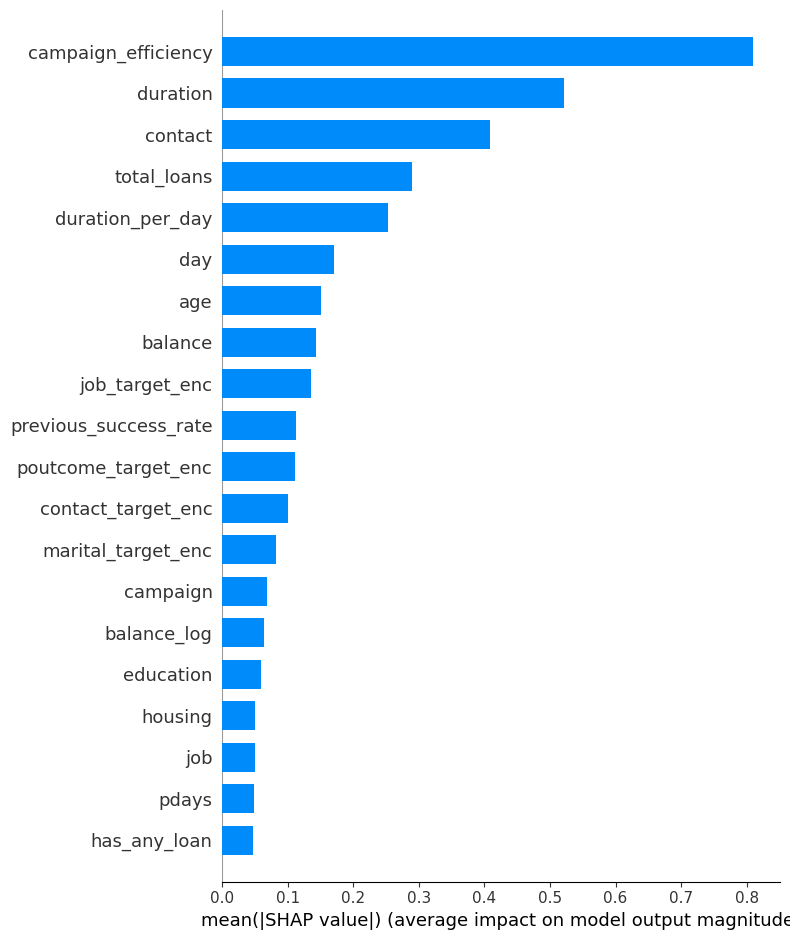

In [13]:
import shap
# 各サンプル × 各特徴の SHAP 値
shap_values = model_lgb.predict(X_valid, pred_contrib=True)

# shap_valuesは numpy配列（shape: [n_samples, n_features + 1])
# 最後の列は "bias term"（全体平均予測値）
shap_values = shap_values[:, :-1]  # bias列を除外

shap.summary_plot(shap_values, X_valid, plot_type="bar")
plt.show()

In [14]:
# テストデータに特徴量エンジニアリングを適用
test_processed, _ = feature_engineering(test_df, is_train=False, encoders=encoders)

# # 特徴量の抽出
X_test = test_processed.drop(columns=['id'])
X_test['age_group_target_enc'] = X_test['age_group_target_enc'].astype('category')

# 各モデルで予測
test_pred_lgb = model_lgb.predict_proba(X_test)[:, 1]




In [15]:
# 最適閾値で二値化
test_pred_final = (test_pred_lgb > best_threshold).astype(int)

# 結果を保存
submission = pd.DataFrame({
    'id': test_df['id'],
    'y': test_pred_final
})

submission.to_csv('/home/takato/bita/bank/data/high_accuracy_submission.csv', index=False, header=False)